In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## Data Preprocessing

In [2]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

#### Train - Test split

In [3]:
# data.to_csv('data.csv')

In [4]:
data = pd.read_csv('data.csv')

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data.y.values, stratify=data.y, test_size=0.2, random_state=10)

print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ",X_test.shape, y_test.shape)

Train data shape:  (32592, 19) (32592,)
Test data shape:  (8148, 19) (8148,)


In [6]:
# split the train data set into D1 and D2
X_d1, X_d2, y_d1, y_d2 = train_test_split(X_train, y_train, stratify=y_train, test_size=0.5, random_state=10)

print("D1 data set shape: ", X_d1.shape, y_d1.shape)
print("D2 data set shape: ",X_d2.shape, y_d2.shape)

D1 data set shape:  (16296, 19) (16296,)
D2 data set shape:  (16296, 19) (16296,)


In [7]:
print("Number of negative and positive data points in D1 (X_d1): ", np.unique(y_d1, return_counts=True))
print("Number of negative and positive data points in D2 (X_d2): ", np.unique(y_d2, return_counts=True))

Number of negative and positive data points in D1 (X_d1):  (array([0, 1]), array([14453,  1843]))
Number of negative and positive data points in D2 (X_d2):  (array([0, 1]), array([14452,  1844]))


#### Data transformation

##### Numerical features scaling

In [9]:
scaler = StandardScaler()
scaler = scaler.fit(X_d1[num_features])

In [68]:
joblib.dump(scaler, 'num_features_scaler.pkl')

['num_features_scaler.pkl']

In [10]:
# creating new empty dataframes to store processed data for training
X_d1_processed = X_d1.drop(cat_features, axis=1)
X_d2_processed = X_d2.drop(cat_features, axis=1)
X_test_processed = X_test.drop(cat_features, axis=1)
X_d1_processed.columns

Index(['Unnamed: 0', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'cons.price.idx', 'cons.conf.idx', 'nr.employed'],
      dtype='object')

In [11]:
X_d1_processed.reset_index(drop=True, inplace=True)
X_d2_processed.reset_index(drop=True, inplace=True)
X_test_processed.reset_index(drop=True, inplace=True)

In [12]:
# transform all numerical features and save it new dataframes
X_d1_processed[num_features] = scaler.transform(X_d1[num_features])
X_d2_processed[num_features] = scaler.transform(X_d2[num_features])
X_test_processed[num_features] = scaler.transform(X_test[num_features])

##### Categorical feature tranformation

* We will tranform categorical features using onehot encoder

In [13]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')
cat_features_ohe = onehotencoder.fit(X_d1[cat_features])

In [67]:
joblib.dump(cat_features_ohe, 'cat_features_ohe.pkl')

['cat_features_ohe.pkl']

In [14]:
X_d1_ohe = cat_features_ohe.transform(X_d1[cat_features])
X_d2_ohe = cat_features_ohe.transform(X_d2[cat_features])
X_test_ohe = cat_features_ohe.transform(X_test[cat_features])

In [15]:
X_d1_ohe.toarray().shape

(16296, 52)

In [16]:
cat_feature_labels_ohe = np.concatenate(cat_features_ohe.categories_).ravel().tolist()

In [17]:
X_d1_ohe = pd.DataFrame(X_d1_ohe.toarray(), columns=cat_feature_labels_ohe)
X_d2_ohe = pd.DataFrame(X_d2_ohe.toarray(), columns=cat_feature_labels_ohe)
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=cat_feature_labels_ohe)

In [18]:
print("shape of categorical features of D1, D2 and test sets after converting categorical features with one hot encoding:")
X_d1_ohe.shape, X_d2_ohe.shape, X_test_ohe.shape

shape of categorical features of D1, D2 and test sets after converting categorical features with one hot encoding:


((16296, 52), (16296, 52), (8148, 52))

##### Merging transformed numerical features and categorical features

In [19]:
X_d1_final = pd.concat([X_d1_ohe, X_d1_processed], axis=1)
X_d2_final = pd.concat([X_d2_ohe, X_d2_processed], axis=1)
X_test_final = pd.concat([X_test_ohe, X_test_processed], axis=1)

X_d1_final.drop('Unnamed: 0', axis=1, inplace=True)
X_d2_final.drop('Unnamed: 0', axis=1, inplace=True)
X_test_final.drop('Unnamed: 0', axis=1, inplace=True)

print("Final processed D1, D2 data and test data shapes: ")
print(X_d1_final.shape, X_d2_final.shape, X_test_final.shape)

Final processed D1, D2 data and test data shapes: 
(16296, 60) (16296, 60) (8148, 60)


## Modeling

In [63]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_cumulative_gain
import joblib

In [21]:
def print_confusion_matrix_accuracy(model, X_test, y_true):
    # print confusion matrix
    y_pred = model.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix_test.flatten()
    accuracy = (tp + tn)/ (tn + fp + fn + tp)
    print("Model Accuracy: ", accuracy)
    
    # code reference - https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix_test.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix_test.flatten()/np.sum(confusion_matrix_test)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix_test, annot=labels, fmt='', cmap='Greens')
    plt.title("Confusion Matrix for Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
        
    return y_pred, accuracy, tn, fp, fn, tp


In [22]:
def plot_auc(model, X_train, X_test, y_train, y_test):
    # AUC
    y_train_pred_prob = model.predict_proba(X_train) # taking only predictions for positive class
    y_test_pred_prob = model.predict_proba(X_test) # taking only predictions for positive class

    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_prob[:, 1])
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_prob[:, 1])

    plt.plot(train_fpr, train_tpr, label='Train AUC:'+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label='Test AUC:'+str(auc(test_fpr, test_tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC curve for train and test sets')
    plt.legend()
    plt.grid()
    plt.show()

    return y_train_pred_prob, y_test_pred_prob, auc(train_fpr, train_tpr), auc(test_fpr, test_tpr)

In [23]:
def precision_recall_f1(y_test, y_pred):
    precision, recall, f1_beta, support = precision_recall_fscore_support(y_test, y_pred) #, average='micro'
    print('Precision Score for class-0:', precision[0], 'and class-1: ', precision[1])
    print('-'*100)
    print('Recall Score for class-0:', recall[0], 'and class-1:', recall[1])
    print('-'*100)
    print('F1 Score for class-0:', f1_beta[0], 'and class-1:', f1_beta[1])
    # print('Support: ', support)
    return precision, recall, f1_beta

In [24]:
def plot_gain_curve(y_true, y_pred_prob, x, y):
    plot_cumulative_gain(y_true, y_pred_prob)
    plt.vlines(x=x, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.hlines(y=y, xmax=0.9, xmin=0, colors='g', linestyles='--')
    # plt.grid()
    plt.show()
    
    # plot_lift_curve(y_test, y_test_pred_prob)

In [25]:
def get_lift_index(y_true, y_pred_prob):
    decile_df = pd.DataFrame(list(zip(y_true, y_pred_prob[:, 1])), columns=['y_true','y_pred'])
    decile_df['decile'] = pd.qcut(decile_df.y_pred, 10, duplicates='drop') #, duplicates='drop'  labels=np.arange(10,0,-1),
    lift_df = decile_df.groupby('decile')['y_pred'].count().reset_index()
    lift_df.rename({'y_pred':'total'}, axis=1, inplace=True)
    lift_df_pred = decile_df[decile_df.y_true==1].groupby('decile')['y_true'].count().reset_index()
    lift_df_final = lift_df.merge(lift_df_pred, on='decile')
    lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

    lift_df_final['decile'] = [(i+1) for i in range(len(lift_df_final.decile.unique()))]
    
    # calculate the weighted lift index value
    w = 1 # initializing the weight to 1
    lift_index = 0.0
    for cnt in lift_df_final.y_true.values:
        lift_index += cnt * w
        w = w - 0.1
    
    lift_index = lift_index/lift_df_final.y_true.sum()
    return lift_index

### Genrating samples with replacement from D1 (X_d1)

In [26]:
def create_sample(inputs, labels):
    """ Function takes input data and target data, select the random samples by sampling with replacement technique 
    from both the datasets and returns the samples """
    
    # number of data points in input data set
    rows = len(inputs)
    # print(rows)
    # select 70% of the rows for each sample
    sample_size = round(rows * 70 / 100)
    # get the indexes of the samples
    sampled_rows = np.random.choice(rows, sample_size, replace=True)
    # print(len(sampled_rows))
    
    # print(sampled_rows[:, None])
    # make the sample for input data and label data with the sampled row indexes
    input_sample = inputs.iloc[sampled_rows]
    labels_sample = labels[sampled_rows]
    
    # print(input_sample.shape, labels_sample.shape)
    return input_sample, labels_sample

In [27]:
def get_samples(X, y, n_samples):
    """ Thi function takes the input data set and target dataset and number of sampes as input and generates the 
    samples and returns a list of generated samples """
    
    # initiate the two lists to store the samples and their targets
    list_input_data = []
    list_target_data = []
    
    for i in range(n_samples):
        # generate n_samples by calling create_sample function and save samples to lists
        input_sample, labels_sample = create_sample(X, y)
        list_input_data.append(input_sample)
        list_target_data.append(labels_sample)
    
    # return the list of generated samples and targets 
    return list_input_data, list_target_data

In [185]:
meta_metrics = dict()
meta_metrics['LGBM'] = dict()
meta_metrics['CAT'] = dict()

In [28]:
# create k=50, 100, 150, 200 samples from D1
k = 100
list_input_data, list_target_data = get_samples(X_d1_final, y_d1, k)

In [29]:
len(list_input_data), len(list_target_data)

(100, 100)

### Training base models on samples

![alt text](summary_tbl.png)

* Based on the performance of the models with hyper parameter tuning, I have chosen the below models

In [30]:
list_classifiers = [LogisticRegression(class_weight='balanced', random_state=10, max_iter=1000),
                    SVC(probability=True, class_weight='balanced', random_state=10),
                    DecisionTreeClassifier(class_weight='balanced', random_state=10),
                    RandomForestClassifier(class_weight='balanced', random_state=10),
                    CatBoostClassifier(class_weights=[0.13, 0.87], random_state=10, silent=True),
                    LGBMClassifier(class_weight='balanced', random_state=10)]

In [49]:
# pick any classification model from the above list and train a model on given sample dataset
# initialize a list to store all trained models
list_models = []
for i in tqdm(range(k)):
    # generate random number and get a classifier randomly from list_classifiers
    idx = np.random.randint(0, len(list_classifiers))
    clf = list_classifiers[idx]
    # train a model with ith sample as input and target
    clf.fit(list_input_data[i], list_target_data[i])
    list_models.append(clf)
    # print(list_models)

100%|██████████| 100/100 [09:08<00:00,  5.48s/it]


#### Prediction of D2 targets with above trained models

In [32]:
def predict_targets(X):
    # initiate a list to store all predictions
    predict_labels = []

    # iterate through each trained model and predict the targets for D2 data set with each model
    for model in tqdm(list_models):
        # predict the target labels for D2 with each trained model
        predict_labels.append(model.predict(X))
        
    return predict_labels

In [50]:
predict_labels = predict_targets(X_d2_final)

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [51]:
# create a meta dataset for training meta model from D2
D_meta_train = np.transpose(np.asarray(predict_labels))
D_meta_train.shape, y_d2.shape

((16296, 100), (16296,))

#### Create test meta dataset for evaluation

In [52]:
predict_labels_test = predict_targets(X_test_final)

100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


In [53]:
# create a meta dataset for evaluation from test data
D_meta_test = np.transpose(np.asarray(predict_labels_test))
D_meta_test.shape, y_test.shape

((8148, 100), (8148,))

### Meta Model - LGBM

In [260]:
# %%time
# # max_depth, min_samples_split, min_samples_leaf
# params = { 'max_depth': [8, 9, 10], 'learning_rate': [0.01, 0.1]} #, 'num_leaves': [256, 512, 1024]

# lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=10, n_jobs=-1)

# grid_lgbm_CV = GridSearchCV(lgbm_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
# grid_lgbm_CV.fit(D_meta_train, y_d2)

# print('Best F1 score for CatBoost Classifier: ', grid_lgbm_CV.best_score_)
# print('Best Params for CatBoost Classifier: ', grid_lgbm_CV.best_params_)

In [54]:
lgbm_meta_clf = LGBMClassifier(class_weight='balanced', random_state=10)

lgbm_meta_clf.fit(D_meta_train, y_d2)

LGBMClassifier(class_weight='balanced', random_state=10)

In [64]:
joblib.dump(lgbm_meta_clf, 'meta_model.pkl')

['meta_model.pkl']

##### Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8628497790868925


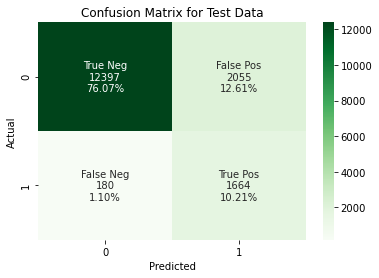

In [55]:
y_train_pred, train_acc, tr_tn, tr_fp, tr_fn, tr_tp = print_confusion_matrix_accuracy(lgbm_meta_clf, D_meta_train, y_d2)

Model Accuracy:  0.865365733922435


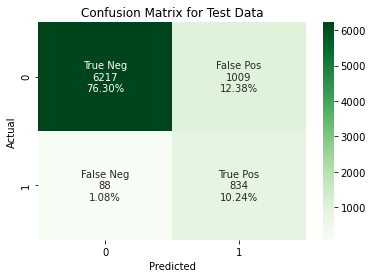

In [56]:
y_test_pred, test_acc, te_tn, te_fp, te_fn, te_tp = print_confusion_matrix_accuracy(lgbm_meta_clf, D_meta_test, y_test)

In [57]:
print("From the above confusion matrix, by targetting ", round(100 * (te_fp + te_tp) / (te_tn + te_fp + te_fn + te_tp)), "% of the leads, we can acheive ", \
      round((100 * te_tp) / (te_fn + te_tp)), "% of the conversion rate. ")

From the above confusion matrix, by targetting  23 % of the leads, we can acheive  90 % of the conversion rate. 


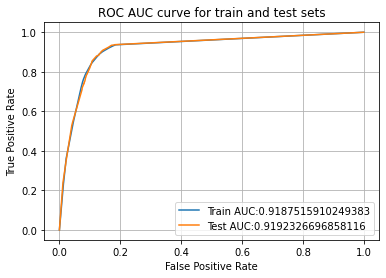

In [58]:
y_train_pred_prob, y_test_pred_prob, train_auc, test_auc = plot_auc(lgbm_meta_clf, D_meta_train, D_meta_test, y_d2, y_test)

In [59]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9860428231562253 and class-1:  0.4525230602278893
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8603653473567673 and class-1: 0.9045553145336226
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9189269085802972 and class-1: 0.6032549728752261


In [60]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9383947939262473

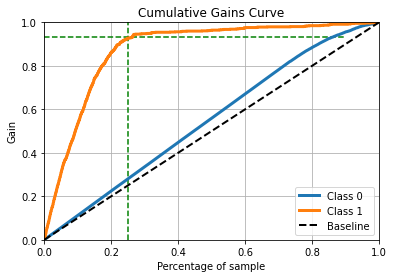

In [45]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=lift_index)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 92.16% of the conversion rate.

In [361]:
meta_metrics['LGBM'][k] = dict()
meta_metrics['LGBM'][k]['trainacc'] = train_acc
meta_metrics['LGBM'][k]['testacc'] = test_acc
meta_metrics['LGBM'][k]['trainauc'] = train_auc
meta_metrics['LGBM'][k]['testauc'] = test_auc
meta_metrics['LGBM'][k]['prec'] = prec
meta_metrics['LGBM'][k]['recal'] = rec
meta_metrics['LGBM'][k]['f1'] = f1
meta_metrics['LGBM'][k]['lift'] = lift_index
meta_metrics['LGBM'][k]['per'] = 25

### Meta Model - CatBoost

In [362]:
cat_meta_clf = CatBoostClassifier(class_weights=[0.13, 0.87], random_state=10, silent=True)

cat_meta_clf.fit(D_meta_train, y_d2)

##### Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8476313205694649


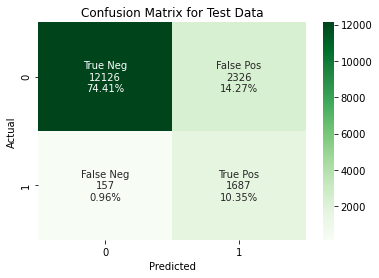

In [363]:
y_train_pred, train_acc, tr_tn, tr_fp, tr_fn, tr_tp = print_confusion_matrix_accuracy(cat_meta_clf, D_meta_train, y_d2)

Model Accuracy:  0.8645066273932254


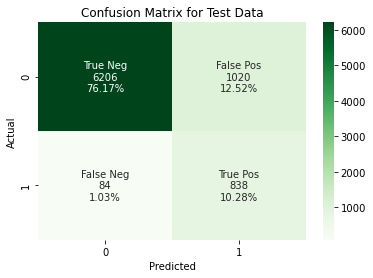

In [337]:
y_test_pred, test_acc, te_tn, te_fp, te_fn, te_tp = print_confusion_matrix_accuracy(cat_meta_clf, D_meta_test, y_test)

In [364]:
print("From the above confusion matrix, by targetting ", round(100 * (te_fp + te_tp) / (te_tn + te_fp + te_fn + te_tp)), "% of the leads, we can acheive ", \
      round((100 * te_tp) / (te_fn + te_tp)), "% of the conversion rate. ")

From the above confusion matrix, by targetting  25 % of the leads, we can acheive  92 % of the conversion rate. 


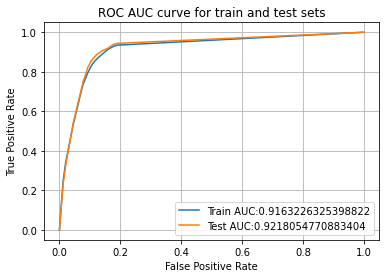

In [365]:
y_train_pred_prob, y_test_pred_prob, train_auc, test_auc = plot_auc(cat_meta_clf, D_meta_train, D_meta_test, y_d2, y_test)

In [366]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9879694358640871 and class-1:  0.4246369554331497
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8409908663160808 and class-1: 0.9197396963123644
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9085744187785003 and class-1: 0.5810208975676602


In [367]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9213665943600867

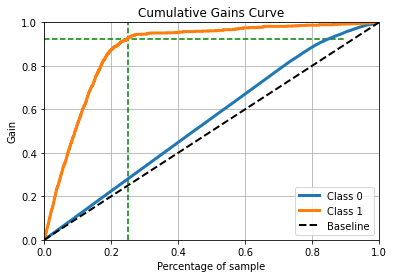

In [369]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=lift_index)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 92.13% of the conversion rate.

In [372]:
meta_metrics['CAT'][k] = dict()
meta_metrics['CAT'][k]['trainacc'] = train_acc
meta_metrics['CAT'][k]['testacc'] = test_acc
meta_metrics['CAT'][k]['trainauc'] = train_auc
meta_metrics['CAT'][k]['testauc'] = test_auc
meta_metrics['CAT'][k]['prec'] = prec
meta_metrics['CAT'][k]['recal'] = rec
meta_metrics['CAT'][k]['f1'] = f1
meta_metrics['CAT'][k]['lift'] = lift_index
meta_metrics['CAT'][k]['per'] = 25

### Summary

In [373]:
from tabulate import tabulate
heads = ['Clf', 'K', 'Tr. Acc', 'Test Acc', 'Tr. AUC', 'Test AUC', \
         'Precision', 'Recall', 'F1', 'Lift Index', '%']

data_table = []
for clf in meta_metrics:
    for K in meta_metrics[clf]:
        data_table.append([clf, K, meta_metrics[clf][K]['trainacc'], meta_metrics[clf][K]['testacc'],
                       meta_metrics[clf][K]['trainauc'], meta_metrics[clf][K]['testauc'],
                       meta_metrics[clf][K]['prec'][1], meta_metrics[clf][K]['recal'][1], 
                       meta_metrics[clf][K]['f1'][1], meta_metrics[clf][K]['lift'], meta_metrics[clf][K]['per']])

print(tabulate(data_table, heads, tablefmt='orgtbl'))

| Clf   |   K |   Tr. Acc |   Test Acc |   Tr. AUC |   Test AUC |   Precision |   Recall |       F1 |   Lift Index |   % |
|-------+-----+-----------+------------+-----------+------------+-------------+----------+----------+--------------+-----|
| LGBM  |  50 |  0.847386 |   0.849902 |  0.916208 |   0.921974 |    0.424637 | 0.91974  | 0.581021 |     0.921692 |  25 |
| LGBM  | 100 |  0.846281 |   0.84487  |  0.918074 |   0.919045 |    0.416094 | 0.91974  | 0.572973 |     0.937744 |  26 |
| LGBM  | 150 |  0.864691 |   0.867452 |  0.918855 |   0.923294 |    0.456498 | 0.899132 | 0.605551 |     0.936117 |  26 |
| LGBM  | 200 |  0.852786 |   0.85162  |  0.91865  |   0.918682 |    0.427268 | 0.914317 | 0.582383 |     0.916377 |  24 |
| CAT   |  50 |  0.847631 |   0.849902 |  0.916323 |   0.921805 |    0.424637 | 0.91974  | 0.581021 |     0.921367 |  25 |
| CAT   | 100 |  0.863525 |   0.864507 |  0.918518 |   0.917216 |    0.451023 | 0.908894 | 0.602878 |     0.931887 |  26 |
| CAT   | 150 | 

* Above is the comparison table - Hyper parameter tuning for number of base learners  
    * Recall is highest at K = 50 for both LGBM and CatBoost models
    * Lift Index is highest at K = 100 and K = 150 in LGBM
    * There is no overfit in any of the models

* We can choose the LGBM with K = 100 as best model, we can acheive 93.7% conversion rate by targetting 26% of the total leads